In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('VGS_clean.csv')

In [4]:
df['year'] = df['year'].apply(lambda s:str(s)[:-2])
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['year'], format="%Y")).year
df.set_index('year', inplace=True)
df.sort_values(by='year', inplace=True)

In [5]:
y = df['global_sales']

In [6]:
y = pd.pivot_table(df ,index = "year" ,
                                       values = "global_sales",
                                       aggfunc = np.sum)

<AxesSubplot:xlabel='year'>

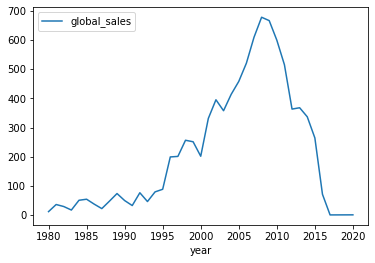

In [7]:
y.plot()

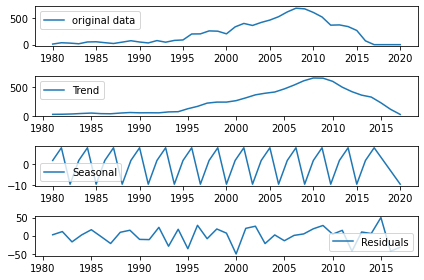

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y, freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'original data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [9]:
from statsmodels.tsa.stattools import kpss
kpss(y)

/Users/gordonmcintire/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.2843899772458229,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<AxesSubplot:xlabel='year'>

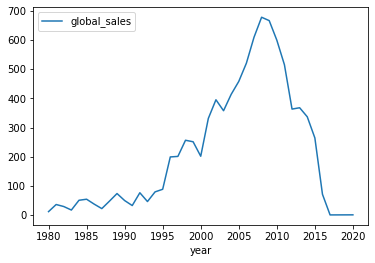

In [29]:
y.plot()

<AxesSubplot:xlabel='year'>

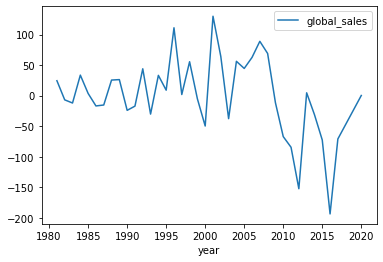

In [11]:
y_diff=y.diff().dropna()
y_diff.plot()

In [12]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [13]:
def evaluate_arima_model(df, arima_order):
    split=int(len(df) * 0.8) 
    train, test = df[0:split], df[split:len(df)]
    past=[x for x in train]
    predictions = list()
    for i in range(len(test)): 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    return error

In [14]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [15]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [17]:
evaluate_models(y, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [19]:
p=2
d=1
q=1
model = ARIMA(y, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

/Users/gordonmcintire/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/gordonmcintire/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.global_sales   No. Observations:                   38
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -208.427
Method:                       css-mle   S.D. of innovations             58.166
Date:                Wed, 28 Jul 2021   AIC                            426.855
Time:                        15:09:19   BIC                            435.043
Sample:                             1   HQIC                           429.768
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1693     19.736     -0.110      0.912     -40.851      36.513
ar.L1.D.global_sales     0.9436      0.409      2.307      0.021       0.142       1.745
ar.L2.D.global_sales    -0.1219      0.239     -0.511      0.610      -0.590       0.346
ma.L1.D.global_sales    -0.6158      0.372     -1.653      0.098      -1.346       0.114
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2673           +0.0000j            1.2673            0.0000
AR.2            6.4724           +0.0000j            6.4724            0.0000
MA.1            1.6238           +0.0000j            1.6238            0.0000
-----------------------------------------------------------------------------
"""

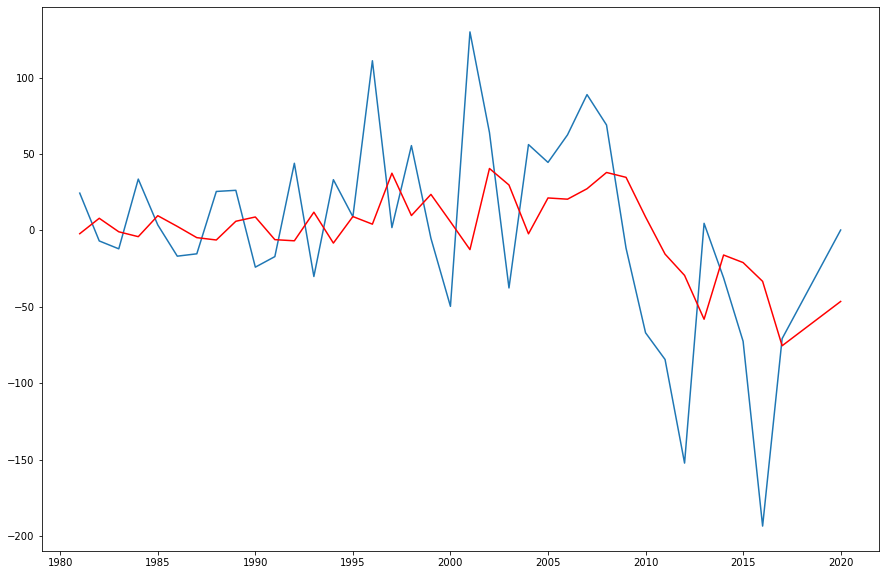

In [22]:
plt.figure(figsize=(15,10))
plt.plot(y.diff())
plt.plot(model_fit.predict(), color = 'red')

ValueError: could not convert string to float: 'Prediction'

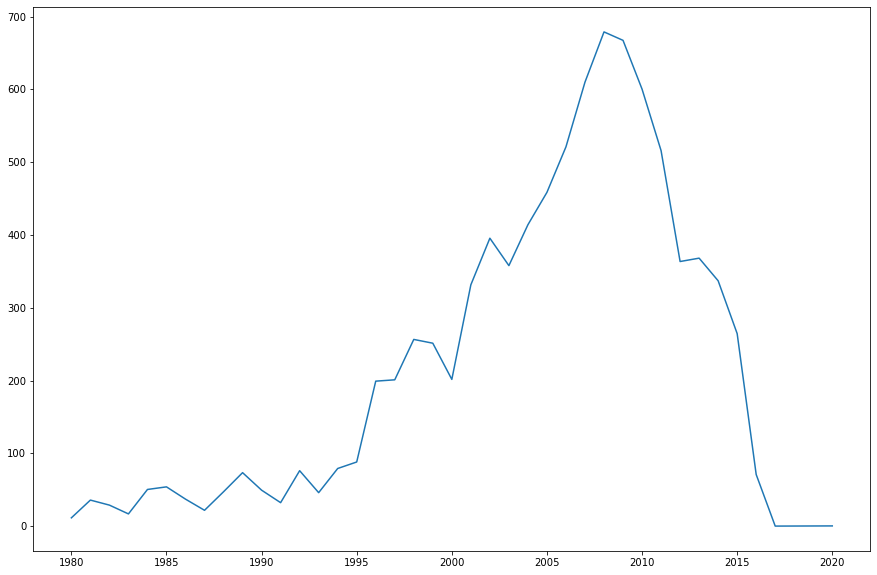

In [35]:

# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 12
date_range = pd.date_range(y.index[-1], periods = forecast_period, 
              freq='MS')

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_years = pd.DataFrame(date_range, columns = ['year'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_years['year'] = pd.to_datetime(future_years['year'])
future_years.set_index('year', inplace = True)

future_years['Prediction'] = pd.Series(forecast[0])

# Plot your future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(y.append(future_years['Prediction']))
plt.show()